In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from lcutils import get_pif_from_file

In [18]:
 # SGR15
# source, scw, flare_start_ijd, duration = "SGR15", '003700020010', 1127.252128, 0.1 # example of good
#source, scw, flare_start_ijd, duration = "SGR15", '003000260010', 1107.0467817, 0.1 # example of bad
# source, scw, flare_start_ijd, duration = "SGR", '0122000850010', 1383.20561475, 1.4 # example of good
source, scw, flare_start_ijd, duration = "SGR", '012100570010', 1379.66877153, 0.24 # example of good
rev = scw[0:4]
! mkdir -p /Users/toast/Dropbox/inaf/test0
! [[ ! -f /Users/toast/Dropbox/inaf/test0/{source}_{scw}_isgri_model.fits.gz ]] && (knock_ssh -H werewolf.lambrate.inaf.it -n; scp werewolf.lambrate.inaf.it:/storage/topinka/{source}/masks/{rev}/{scw}_isgri_model.fits.gz /Users/toast/Dropbox/inaf/test0/{source}_{scw}_isgri_model.fits.gz)
! [[ ! -f /Users/toast/Dropbox/inaf/test0/{scw}_isgri_events.fits.gz ]] && (knock_ssh -H werewolf.lambrate.inaf.it -n; scp werewolf.lambrate.inaf.it:/anita/archivio/scw/{rev}/{scw}.001/isgri_events.fits.gz /Users/toast/Dropbox/inaf/test0/{scw}_isgri_events.fits.gz)
! [[ ! -f /Users/toast/Dropbox/inaf/test0/{source}_{scw}_evts_h.fits.gz ]] && (knock_ssh -H werewolf.lambrate.inaf.it -n; scp werewolf.lambrate.inaf.it:/storage/topinka/{source}/out/{rev}/{scw}_evts_h.fits.gz /Users/toast/Dropbox/inaf/test0/{source}_{scw}_evts_h.fits.gz)

In [19]:
# scw = "012200850010"
fn_raw = f'/Users/toast/Dropbox/inaf/test0/{scw}_isgri_events.fits.gz'
fn = f'/Users/toast/Dropbox/inaf/test0/{source}_{scw}_evts_h.fits.gz'
# let's for test take a different pif if things changed with a completely different pif
# scw = "012200460010"
fn_pif = f'/Users/toast/Dropbox/inaf/test0/{source}_{scw}_isgri_model.fits.gz'
!ls {fn_raw} {fn} {fn_pif}

/Users/toast/Dropbox/inaf/test0/012100570010_isgri_events.fits.gz
/Users/toast/Dropbox/inaf/test0/SGR_012100570010_evts_h.fits.gz
/Users/toast/Dropbox/inaf/test0/SGR_012100570010_isgri_model.fits.gz


In [20]:
pif_th = 0.5 # nearly fully-coded
low_e = 20
high_e = 150

#flare_start_ijd = 1107.0467817
#duration = 0.02
flare_end_ijd =  flare_start_ijd + duration/(24*60*60)
boundary = 0.01/(24*60*60)

In [21]:
with fits.open(fn_raw) as hdul:
    time = hdul['ISGR-EVTS-ALL'].data['TIME']
    energy = hdul['ISGR-EVTS-ALL'].data['ISGRI_ENERGY']
    dety = hdul['ISGR-EVTS-ALL'].data['DETY'].astype(int)
    detz = hdul['ISGR-EVTS-ALL'].data['DETZ'].astype(int)
    select_flag = hdul['ISGR-EVTS-ALL'].data['SELECT_FLAG'] == 0

In [22]:
pifmask = get_pif_from_file(fn_pif)

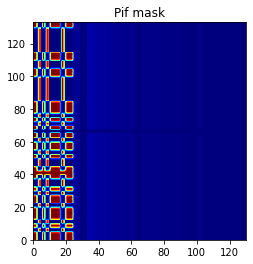

In [23]:
pif = pifmask[detz, dety]
plt.imshow(pifmask.T,
           interpolation=None,
           vmin=0, vmax=1,
           origin='lower',
           extent=[0, 130, 0, 133],
           cmap=plt.cm.jet)
plt.title("Pif mask");
#pifmask.shape

In [24]:
with fits.open(fn) as hdul:
    time = hdul['GNRL-EVTS-LST'].data['TIME']
    energy = hdul['GNRL-EVTS-LST'].data['ENERGY']
    dety = (hdul['GNRL-EVTS-LST'].data['DETY']/4.6).astype(int)
    detz = (hdul['GNRL-EVTS-LST'].data['DETZ']/4.6).astype(int)
    pif = hdul['GNRL-EVTS-LST'].data['PIF_1']
    select_flag = hdul['GNRL-EVTS-LST'].data['EVNT_TYPE'] == 0

In [25]:
np.min(detz), np.max(detz), np.min(dety), np.max(dety)

(0, 133, 0, 129)

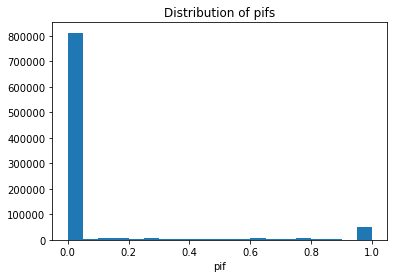

In [26]:
plt.hist(pif,bins=20)
plt.title("Distribution of pifs")
plt.xlabel("pif");

In [27]:
filtr = (time >= flare_start_ijd - boundary) & \
        (time <= flare_end_ijd + boundary) & \
        (energy >= low_e) & \
        (energy <= high_e) & \
        (select_flag) & \
        (pif >= pif_th)

dety_target = dety[filtr]
detz_target = detz[filtr]
n_photons = np.count_nonzero(filtr)
n_photons

44

In [28]:
H, xedges, yedges = np.histogram2d(detz_target, dety_target,
                                   bins=pifmask.shape,
                                   range=[[0,133],[0,129]])

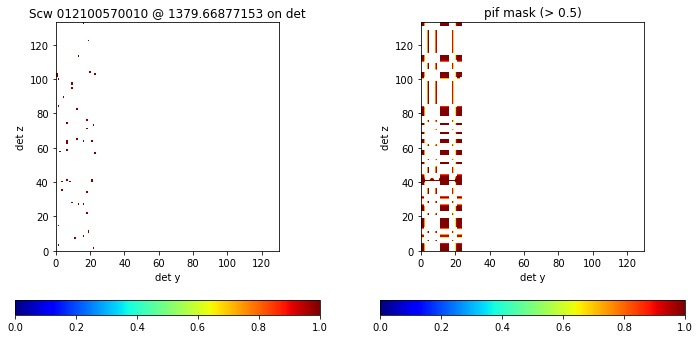

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(121)
# masking < pif_th to look white
data_masked = np.ma.masked_where(H.T < 0.001, H.T)
im = plt.imshow(data_masked, 
           interpolation = 'none', 
           origin='lower', 
           vmin = 0, 
           cmap=plt.cm.jet,
           extent=[0, 130, 0, 133])
plt.colorbar(im, orientation="horizontal", pad=0.15)
plt.xlabel("det y")
plt.ylabel("det z")
plt.title("Scw {0} @ {1} on det".format(scw, flare_start_ijd));

plt.subplot(122)
pifmask_masked = np.ma.masked_where(pifmask < pif_th, pifmask)
im = plt.imshow(pifmask_masked.T,
           interpolation=None,
           vmin=0, vmax=1,
           origin='lower',
           extent=[0, 130, 0, 133],
           cmap=plt.cm.jet)
plt.colorbar(im, orientation="horizontal", pad=0.15)
plt.xlabel("det y")
plt.ylabel("det z")
plt.title("pif mask (> {0})".format(pif_th));

In [30]:
i = pifmask >= pif_th
i.shape, np.count_nonzero(i)

((134, 130), 1301)

In [31]:
p = H[i].ravel()
nz = np.count_nonzero(p)
c = p[p > 0].ravel()

44 photons on 44 of 1301 illuminated pixels
Expected 1 photon(s) on a pixel. Max per pixel 1, var 0


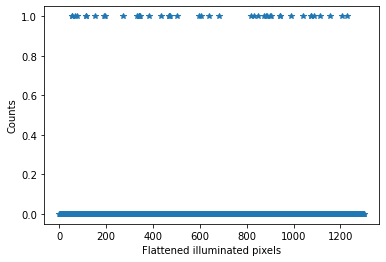

In [32]:
plt.plot(p,"*")
plt.xlabel('Flattened illuminated pixels')
plt.ylabel('Counts')
npx_pif = np.count_nonzero(i)
expected = n_photons//npx_pif + 1
var = np.sum( (c - expected)**2)/len(c)
print("{0:g} photons on {1:g} of {2:g} illuminated pixels".format(n_photons, nz, npx_pif))
print("Expected {0:g} photon(s) on a pixel. Max per pixel {1:g}, var {2:g}".format(expected, np.max(c), var))

In [33]:
var > expected + 3*np.sqrt(expected)

False

In [34]:
np.sum(H.ravel())

44.0